# thal2 3:4 1k Bifurcation Diagrams

# Inits

## Imports

In [1]:
import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is
# user-defined
import nmCoupling as nm
# import nmCoupling_old as nm
import response as rp

import thal2 as t2

from lib.util import (get_phase, freq_est,follow_phase_diffs,follow_phase_diffs_del,
                        follow_phase_diffs_u,follow_phase_diffs_u_del,
get_smallest_eps,get_largest_eps, get_es_min, get_es_max)

from lib.rhs import _redu_c2,_full, _redu_full, _full, _full_mono_rhs

from lib.plot_util import (add_diagram_1d_scatter, quick_plot_combined, 
                            draw_quick_plot_f, add_diagram_1d_del_scatter)


import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sym

from scipy.signal import find_peaks
from scipy.optimize import root,bisect
from copy import deepcopy
import os

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

nmc = nm.nmCoupling
rsp = rp.Response

## Dicts

In [2]:
kw_sim = {'rtol':1e-9,'atol':1e-9,'method':'LSODA'}

In [3]:
pd1 = {'gL':0.05,'gna':3,'gk':5,
       'gt':5,'eL':-70,'ena':50,
       'ek':-90,'et':0,'esyn':0,
       'c':1,'alpha':3,'beta':2,
       'sigmat':0.8,'vt':-20,
       'ib':8.5,'del':0,'om':1,'om_fix':1}

In [4]:
# default period must be 2*np.pi
kws1 = {'var_names':['v','h','r','w'],
        'pardict':pd1,
        'rhs':t2.rhs,
        'coupling':t2.coupling,
        'init':np.array([-.64,0.71,0.25,0,6]),
        'TN':20000,
        'trunc_order':1,
        'z_forward':False,
        'i_forward':[False,True,False,False,False,False],
        'i_bad_dx':[False,True,False,False,False,False],
        'max_iter':50,
        'rtol':1e-12,
        'atol':1e-12,
        'rel_tol':1e-9,
        'save_fig':False,
        'lc_prominence':.05,
        'factor':1}

## Defs

In [5]:
#### es_min,phi0 = get_es_min(data_bs_list,data_bu_list)
def get_monodromy_full(es_min,phi0,a,b,mname='',tol=1e-6,recompute=False):
    """
    es_min: minimum epsilon to use
    a: nmCoupling object
    b: het. parameter.
    mnamei are the model names to save the monodromy matrix and related calculations
    """    

    kw_b = {'a':a,'b':b,'recompute':recompute,'bifdir':'bif1d_thal2/','_full_rhs':_full}
    print('es_min,phi0',es_min,phi0)
    # the _u function has the ability to save and load Y values
    _,Y = follow_phase_diffs(**dict(phi0=phi0,eps_init=es_min,eps_final=es_min-.01,deps=-1),max_time=10000,tol=tol,return_point=True,**kw_b)

    print('Y',Y)
    # define parameters for finding monodromy of full system
    pd_vdp_thal = {**a.system1.pardict,**a.system2.pardict}
    pd_vdp_thal['b']=b
    pd_vdp_thal['a']=a
    
    pd_vdp_thal['eps']=es_min
    # print(pd1['del0'])
    
    # default period must be 2*np.pi
    kws_vdp_thal = {'var_names':['v0','h0','r0','w0','v1','h1','r1','w1'],
                    'pardict':pd_vdp_thal,
                    'rhs':_full_mono_rhs,
                    'coupling':lambda x: 0*x,
                    'init':Y, # from above
                    'use_init':True, # use init for direct LC calculation
                    'TN':50000,
                    'mode':'none', # forces not normalizing period.
                    'rtol_lc':1e-10,
                    'atol_lc':1e-10,
                    'trunc_order':0,
                    'z_forward':False,
                    'i_forward':False,
                    'i_bad_dx':[False,True,False,False,False,False],
                    'save_fig':False,
                    'max_iter':50,
                    'max_time_lc':5000,
                    'tol_root_lc':1e-8,
                    'halt_after_mono':True}

    m1 = rsp(idx='',model_name=mname,**kws_vdp_thal)

    return m1

In [6]:
kw_bif = {'method':'LSODA','dense_output':True,'rtol':1e-9,'atol':1e-9}

In [7]:
x_temp = np.linspace(-np.pi,3*np.pi,500)

In [8]:
ss,dss=np.linspace(0,2,100,retstep=True)

In [9]:
def compute_sol_all(a,eps,phi0,b,T=2000,dt=.01):
    """
    only for use in jupyter
    """
    t = np.arange(0,T,dt)
    args = {'args':(a,eps,b), 't_eval':t,**kw_sim}

    y0a = a.system1.lc['dat'][int((phi0/(2*np.pi)) * a.system1.TN),:]
    y0b = a.system2.lc['dat'][int((0/(2*np.pi)) * a.system2.TN),:]
    y0 = np.array([y0a,y0b]).flatten()
    #a.system1.pardict['del0'] = b

    solf = solve_ivp(_full,[0,t[-1]], y0, **args)

    args['args'] = (a,eps,b,1)
    solr_o1 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)
    
    args['args'] = (a,eps,b,2)
    solr_o2 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)
    
    #args['args'] = (a,eps,b,3)
    #solr_o3 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)
    
    #args['args'] = (a,eps,b,4)
    #solr_o4 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)

    return solf, solr_o1, solr_o2#, solr_o3, solr_o4


def load_sol_all(a,eps,phi0,b,T,dt=.01,path_loc='sols_temp/',recompute=True):
    if (not os.path.exists(path_loc)):
        os.makedirs(path_loc)
    
    fname_f = 'sol_f_thal2_nm={}{}_eps={}_b={}_T={}_phi0={}.dat'.format(a._n[1],a._m[1],eps,b,T,phi0)
    fname_r = 'sol_r_thal2_nm={}{}_eps={}_b={}_T={}_phi0={}.dat'.format(a._n[1],a._m[1],eps,b,T,phi0)

    fname_f = path_loc + fname_f
    fname_r = path_loc + fname_r

    print('full',fname_f)
    print('redu',fname_r)
    
    file_dne = not(os.path.isfile(fname_f))
    file_dne += not(os.path.isfile(fname_r))

    if file_dne or recompute:
        solf, solr_o1, solr_o2 = compute_sol_all(a,eps,phi0,b,T=T,dt=dt)

        # phase of full model
        ta, pha = get_phase(solf.t,solf.y.T[:,:4], skipn=200,system1=a.system1)
        tb, phb = get_phase(solf.t,solf.y.T[:,4:], skipn=200,system1=a.system2)

        dat1 = np.zeros([len(ta),2])
        dat1[:,0] = ta
        dat1[:,1] = np.mod(pha - a.om*phb,2*np.pi)

        dat2 = np.zeros([len(solr_o1.t),5])
        dat2[:,0] = solr_o1.t
        dat2[:,1] = solr_o1.y[0]
        dat2[:,2] = solr_o2.y[0]

        np.savetxt(fname_f,dat1)
        np.savetxt(fname_r,dat2)

    else:
        dat1 = np.loadtxt(fname_f)
        dat2 = np.loadtxt(fname_r)
    return dat1, dat2

## Initialize Response Functions

In [10]:
system1 = rsp(idx=0,model_name='thal0_85_1k',**kws1)
system2 = rsp(idx=1,model_name='thal1_85_1k',**kws1)

mkdir ./data/thal0_85_1k/
* Loading LC data...
self.T 6.283185307179586 omfix 0.990198152249508
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.02435447577890923
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...
mkdir ./data/thal1_85_1k/
* Loading LC data...
self.T 6.283185307179586 omfix 0.990198152249508
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.02435447577890923
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...


# Initialize Coupling 3:4

In [11]:
het_coeffs = [1,1000]

In [12]:
#recompute_list = ['k_thal0_85','k_thal1_85','h_thal0_85','h_thal1_85', 'h_data_thal0_85','h_data_thal1_85', 'p_data_thal0_85','p_data_thal1_85','p_thal0_85','p_thal1_85']
# recompute_list = ['k_thal0_85','k_thal1_85']
nm_tup = (3,4)
recompute_list = []
kw_nm = {'system1':system1,'system2':system2,'_n':('om0',nm_tup[0]),'_m':('om1',nm_tup[1]),
         'NH':1024,'save_fig':False, 'recompute_list':recompute_list,
         'het_coeffs':het_coeffs, # [eps, eps^2, etc]
        }
a = nm.nmCoupling(**kw_nm)
nm_val = str(nm_tup[0])+str(nm_tup[1])

Initializing 34 Coupling...
pfactor 30
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
* Loading H symbolic...
* Loading H symbolic...
* Loading H thal0_85_1k, order=0...
* Loading H thal1_85_1k, order=0...
* Loading H thal0_85_1k, order=1...
* Loading H thal1_85_1k, order=1...


### Plot 1par eps

In [13]:
etup = (.001,.2,100)

<Axes: >

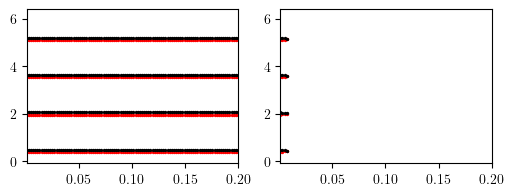

In [14]:
fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a,b=0.0021,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

In [15]:
# fig,axs = plt.subplots(1,2,figsize=(6,2))
# kw_diagram = dict(a=a,b=-.0019,eps_tup=etup,rhs=_redu_c2)
# add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

In [16]:
# fig,axs = plt.subplots(1,2,figsize=(6,2))
# kw_diagram = dict(a=a,b=0,eps_tup=etup,rhs=_redu_c2)
# add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

In [17]:
# fig,axs = plt.subplots(1,2,figsize=(6,2))
# kw_diagram = dict(a=a,b=0.001,eps_tup=etup,rhs=_redu_c2)
# add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

In [18]:
# fig,axs = plt.subplots(1,2,figsize=(6,2))
# kw_diagram = dict(a=a,b=0.0013,eps_tup=etup,rhs=_redu_c2)
# add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

### Plot 1par del

In [19]:
dtup = (-.01,.01,100)

In [20]:
# fig,axs = plt.subplots(1,2,figsize=(6,2))
# kw_diagram = dict(a=a,eps=0.1,del_tup=dtup,rhs=_redu_c2)
# add_diagram_1d_del_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_del_scatter(axs[1],miter=2,**kw_diagram)

## EPS VARY

In [21]:
kw_b = {'a':a,'b':0,'recompute':False,'bifdir':'bif1d_thal2_1k/','_full_rhs':_full}
fname_bs = kw_b['bifdir']+'hyper_thal2_'+nm_val+'_b={}_s.txt'
fname_bu = kw_b['bifdir']+'hyper_thal2_'+nm_val+'_b={}_u.txt'

In [22]:
mname_list = ['thal2_'+nm_val+'_b'+str(i)+'={}' for i in range(5)]

In [23]:
b_vals_full = []
e_vals_full = [] # save min eps values for all diagrams
e_hi_full = [] # save max eps values for all diagrams

## monodromy calculations
e_vals_mono_min = [] # save eps values at min monodromy
eigenvalues_min_all = []
b_min_all = []

e_vals_mono_max = [] # save eps values at max monodromy
eigenvalues_max_all = []
b_max_all = []

### b=0.002

#### Branches eps stable

In [24]:
b=0.002
kw_b['recompute'] = False
kw_b['b'] = b

In [25]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [
    dict(phi0=2,eps_init=0.025,eps_final=0,deps=-.001),
    dict(phi0=2,eps_init=0.02499,eps_final=.2,deps=.001),
]

In [26]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 2
phi init 2


In [27]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

In [28]:
kw_b['recompute'] = False
kw_b['b'] = 0
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.3,eps_init=0.01,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)
print(da)
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.3,eps_init=0.02,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.3,eps_init=0.03,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.3,eps_init=0.04,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.3,eps_init=0.05,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da,list(Yinit))
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.3,eps_init=0.06,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.3,eps_init=0.07,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.3,eps_init=0.08,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.3,eps_init=0.09,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.3,eps_init=0.1,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da,list(Yinit))

phi init 3.3
phase_diffs_u_init=3.3_nm=34_b=0_ei=0.01_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.3_nm=34_b=0_ei=0.01_ef=0_de=-2.txt
[0.01       2.08927176 2.08927176 2.08927176 2.08927176 1.59229898 3.17738028 4.75704834 0.03247953]
phi init 3.3
phase_diffs_u_init=3.3_nm=34_b=0_ei=0.02_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.3_nm=34_b=0_ei=0.02_ef=0_de=-2.txt
[0.02       2.08480508 2.08480508 2.08480508 2.08480508 5.51767827 0.78238436 2.35257792 3.95893717]
phi init 3.3
phase_diffs_u_init=3.3_nm=34_b=0_ei=0.03_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.3_nm=34_b=0_ei=0.03_ef=0_de=-2.txt
[0.03       2.08069492 2.08069492 2.08069492 2.08069492 5.51615756 0.76904094 2.34134717 3.96800969]
phi init 3.3
phase_diffs_u_init=3.3_nm=34_b=0_ei=0.04_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.3_nm=34_b=0_ei=0.04_ef=0_de=-2.txt
[0.04       2.07536151 2.07536151 2.07536151 2.07536151 5.5141864  0.75487032 2.32718042 3.96609673]
phi init 3.3
phase_diffs_u_init=3.3_nm=34_b=0_ei=0.05_ef=0_de=-2.txt
phase_diffs_u_p

#### Branches eps unstable

Obtain an unstable phase-locked state with parameters that make one easy to find ($b=0$ and $|\varepsilon| \ll 1$) and use it to find an unstable phase-locked state for $b\neq0$.

In [29]:
kw_b['recompute'] = False
kw_b['b'] = 0
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.3,eps_init=0.01,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = .001
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.3,eps_init=0.02,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = .0012
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.3,eps_init=0.03,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = .0013
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.3,eps_init=0.035,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = .0014
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.3,eps_init=0.03,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = .0015
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.3,eps_init=0.025,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = .0016
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.3,eps_init=0.024,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = .0017
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.3,eps_init=0.023,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = .0018
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.3,eps_init=0.022,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = .0019
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.3,eps_init=0.021,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)

phi init 3.3
phase_diffs_u_init=3.3_nm=34_b=0_ei=0.01_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.3_nm=34_b=0_ei=0.01_ef=0_de=-2.txt
[0.01       2.08927176 2.08927176 2.08927176 2.08927176 1.59229898 3.17738028 4.75704834 0.03247953]
phi init 3.3
phase_diffs_u_init=3.3_nm=34_b=0.001_ei=0.02_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.3_nm=34_b=0.001_ei=0.02_ef=0_de=-2.txt
[0.02       2.08447174 2.08447174 2.08447174 2.08447174 1.71171435 3.31431142 4.89761705 0.1615659 ]
phi init 3.3
phase_diffs_u_init=3.3_nm=34_b=0.0012_ei=0.03_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.3_nm=34_b=0.0012_ei=0.03_ef=0_de=-2.txt
[0.03       2.07980507 2.07980507 2.07980507 2.07980507 1.73045896 3.35034739 4.93821267 0.19093053]
phi init 3.3
phase_diffs_u_init=3.3_nm=34_b=0.0013_ei=0.035_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.3_nm=34_b=0.0013_ei=0.035_ef=0_de=-2.txt
[0.035      2.07753839 2.07753839 2.07753839 2.07753839 1.74121838 3.37053585 4.95932705 0.20626058]
phi init 3.3
phase_diffs_u_init=3.3_nm=34_b=0.0014_ei=

In [30]:
kw_b['b'] = b
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.3,eps_init=0.021,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)

phi init 3.3
phase_diffs_u_init=3.3_nm=34_b=0.002_ei=0.021_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.3_nm=34_b=0.002_ei=0.021_ef=0_de=-2.txt
[0.021      2.08402829 2.08402829 2.08402829 2.08402829 5.0892595  0.35576577 1.90545735 3.51544821]


In [31]:
in_dicts = [dict(phi0=4,eps_init=0.021,eps_final=0,deps=-.005),
            dict(phi0=4,eps_init=0.0209999,eps_final=0.2,deps=.001),
           ]

In [32]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 4
phase_diffs_u_init=4_nm=34_b=0.002_ei=0.021_ef=0_de=-0.005.txt
phase_diffs_u_pt_init=4_nm=34_b=0.002_ei=0.021_ef=0_de=-0.005.txt
phi init 4
phase_diffs_u_init=4_nm=34_b=0.002_ei=0.0209999_ef=0.2_de=0.001.txt
phase_diffs_u_pt_init=4_nm=34_b=0.002_ei=0.0209999_ef=0.2_de=0.001.txt


In [33]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

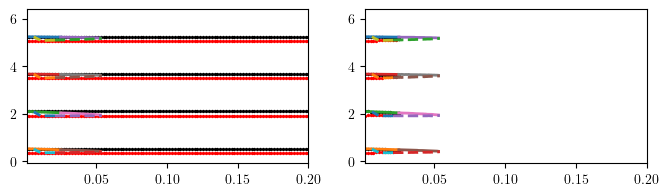

In [34]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys max

In [35]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.05399990000000003 3.5877898710561986
phi init 3.5877898710561986
Y [ 9.65960839e-01  1.11409397e+00 -4.69860361e-02 -2.14325191e-03 -7.26746640e+00  3.55789231e+00  6.29573661e+00 -6.61867249e+00  1.19381534e+01]
mkdir ./data/thal2_34_b0=0.002/
* Loading LC data...
self.T 6.221055455641457
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0010512925742389156
es_min,phi0 0.05349990000000003 3.5877898710561986
phi init 3.5877898710561986
Y [-0.108298    0.21777868  0.08981309  0.41493176 -0.60585198  0.21743477  0.08784442  0.05221302  6.20981719]
mkdir ./data/thal2_34_b1=0.002/
* Loading LC data...
self.T 6.221718883265309
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0010666178646960192
es_min,phi0 0.05299990000000003 3.5877898710561986
phi init 3.5877898710561986
Y [-0.10825472  0.23843338  0.08992461  0.39074941 -0.60286375  0.20957607  0.08776184  0.05600594  6.21047839]
mkdir ./data/thal2_34_b2=0.002/
* L

In [36]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(0)

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=0.0019

#### Sim

full sols_temp/sol_f_thal2_nm=34_eps=0.1_b=0.0021_T=3000_phi0=4.dat
redu sols_temp/sol_r_thal2_nm=34_eps=0.1_b=0.0021_T=3000_phi0=4.dat


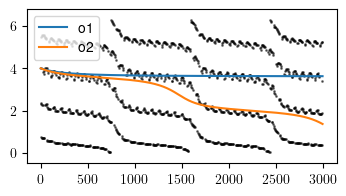

In [37]:
a=a;T=3000;b=0.0021;e=.1;phi0 = 4
dat1,dat2=load_sol_all(a=a,eps=e,phi0=phi0,b=b,T=T,recompute=False)
t1=dat1[:,0];y=dat1[:,1]
t2=dat2[:,0];so1=dat2[:,1];so2=dat2[:,2]

fig,axs = plt.subplots(figsize=(4,2))

axs.scatter(t1,y,s=1,alpha=.5,color='black')

axs.plot(t2,np.mod(so1,2*np.pi),label='o1')
axs.plot(t2,np.mod(so2,2*np.pi),label='o2')

axs.set_ylim(-.5,2*np.pi+.5)
axs.legend()

#### Branches eps stable

In [38]:
b=0.0019
kw_b['recompute'] = False
kw_b['b'] = b

In [39]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [
    dict(phi0=2,eps_init=0.025,eps_final=0,deps=-.001),
    dict(phi0=2,eps_init=0.02499,eps_final=.2,deps=.01),
]

In [40]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 2
phi init 2


In [41]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

Obtain an unstable phase-locked state with parameters that make one easy to find ($b=0$ and $|\varepsilon| \ll 1$) and use it to find an unstable phase-locked state for $b\neq0$.

In [42]:
kw_b['recompute'] = False
kw_b['b'] = 0
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.3,eps_init=0.01,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = .001
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.3,eps_init=0.02,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = .0012
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.3,eps_init=0.03,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = .0013
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.3,eps_init=0.035,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = .0014
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.3,eps_init=0.03,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = .0015
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.3,eps_init=0.025,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = .0016
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.3,eps_init=0.024,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = .0017
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.3,eps_init=0.023,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = .0018
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.3,eps_init=0.022,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = .0019
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.3,eps_init=0.021,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)

phi init 3.3
phase_diffs_u_init=3.3_nm=34_b=0_ei=0.01_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.3_nm=34_b=0_ei=0.01_ef=0_de=-2.txt
[0.01       2.08927176 2.08927176 2.08927176 2.08927176 1.59229898 3.17738028 4.75704834 0.03247953]
phi init 3.3
phase_diffs_u_init=3.3_nm=34_b=0.001_ei=0.02_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.3_nm=34_b=0.001_ei=0.02_ef=0_de=-2.txt
[0.02       2.08447174 2.08447174 2.08447174 2.08447174 1.71171435 3.31431142 4.89761705 0.1615659 ]
phi init 3.3
phase_diffs_u_init=3.3_nm=34_b=0.0012_ei=0.03_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.3_nm=34_b=0.0012_ei=0.03_ef=0_de=-2.txt
[0.03       2.07980507 2.07980507 2.07980507 2.07980507 1.73045896 3.35034739 4.93821267 0.19093053]
phi init 3.3
phase_diffs_u_init=3.3_nm=34_b=0.0013_ei=0.035_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.3_nm=34_b=0.0013_ei=0.035_ef=0_de=-2.txt
[0.035      2.07753839 2.07753839 2.07753839 2.07753839 1.74121838 3.37053585 4.95932705 0.20626058]
phi init 3.3
phase_diffs_u_init=3.3_nm=34_b=0.0014_ei=

In [43]:
in_dicts = [dict(phi0=4,eps_init=0.021,eps_final=0,deps=-.005),
            dict(phi0=4,eps_init=0.0209999,eps_final=0.2,deps=.004),
           ]

In [44]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 4
phase_diffs_u_init=4_nm=34_b=0.0019_ei=0.021_ef=0_de=-0.005.txt
phase_diffs_u_pt_init=4_nm=34_b=0.0019_ei=0.021_ef=0_de=-0.005.txt
phi init 4
phase_diffs_u_init=4_nm=34_b=0.0019_ei=0.0209999_ef=0.2_de=0.004.txt
phase_diffs_u_pt_init=4_nm=34_b=0.0019_ei=0.0209999_ef=0.2_de=0.004.txt


In [45]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

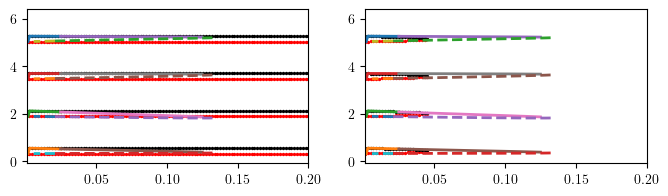

In [46]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys max

In [47]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.1329999 3.629704818464562
phi init 3.629704818464562
Y [-0.10863558  0.22676814  0.08481818  0.40364259 -0.59544682  0.20065187  0.08256972  0.06037059  6.11461074]
mkdir ./data/thal2_34_b0=0.0019/
* Loading LC data...
self.T 6.1146107705687625
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = (-0.0009523277662914515+0j)
es_min,phi0 0.1324999 3.629704818464562
phi init 3.629704818464562
Y [-0.10863286  0.22936899  0.08485293  0.40058356 -0.59500748  0.19954363  0.08258677  0.06099065  6.11516965]
mkdir ./data/thal2_34_b1=0.0019/
* Loading LC data...
self.T 6.115169692811071
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0010629371296358334
es_min,phi0 0.1319999 3.629704818464562
phi init 3.629704818464562
Y [-1.18887515e-01  2.33064685e-01  8.46571867e-02  3.84450598e-01 -3.80773880e-01  6.47742118e-01  8.54536294e-02  1.19471647e-05  6.11572820e+00]
mkdir ./data/thal2_34_b2=0.0019/
* Loading LC data...
self.T 6.

In [48]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(0)

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=0.0018

#### Branches eps stable

In [49]:
b=0.0018
kw_b['recompute'] = False
kw_b['b'] = b

In [50]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [
    dict(phi0=2,eps_init=0.04,eps_final=0,deps=-.002),
    dict(phi0=2,eps_init=0.0399,eps_final=.2,deps=.01),
]

In [51]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 2
phi init 2


In [52]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

Obtain an unstable phase-locked state with parameters that make one easy to find ($b=0$ and $|\varepsilon| \ll 1$) and use it to find an unstable phase-locked state for $b\neq0$.

In [53]:
kw_b['recompute'] = False
kw_b['b'] = 0

In [54]:
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.3,eps_init=0.01,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)
print(da)

phi init 3.3
phase_diffs_u_init=3.3_nm=34_b=0_ei=0.01_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.3_nm=34_b=0_ei=0.01_ef=0_de=-2.txt
[0.01       2.08927176 2.08927176 2.08927176 2.08927176 1.59229898 3.17738028 4.75704834 0.03247953]


In [55]:
kw_b['recompute'] = False
kw_b['b'] = .001

In [56]:
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.3,eps_init=0.02,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)

phi init 3.3
phase_diffs_u_init=3.3_nm=34_b=0.001_ei=0.02_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.3_nm=34_b=0.001_ei=0.02_ef=0_de=-2.txt
[0.02       2.08447174 2.08447174 2.08447174 2.08447174 1.71171435 3.31431142 4.89761705 0.1615659 ]


In [57]:
kw_b['recompute'] = False
kw_b['b'] = .0012

In [58]:
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.3,eps_init=0.03,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)

phi init 3.3
phase_diffs_u_init=3.3_nm=34_b=0.0012_ei=0.03_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.3_nm=34_b=0.0012_ei=0.03_ef=0_de=-2.txt
[0.03       2.07980507 2.07980507 2.07980507 2.07980507 1.73045896 3.35034739 4.93821267 0.19093053]


In [59]:
kw_b['recompute'] = False
kw_b['b'] = .0013

In [60]:
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.3,eps_init=0.035,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)

phi init 3.3
phase_diffs_u_init=3.3_nm=34_b=0.0013_ei=0.035_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.3_nm=34_b=0.0013_ei=0.035_ef=0_de=-2.txt
[0.035      2.07753839 2.07753839 2.07753839 2.07753839 1.74121838 3.37053585 4.95932705 0.20626058]


In [61]:
kw_b['recompute'] = False
kw_b['b'] = b

In [62]:
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.3,eps_init=0.04,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)

phi init 3.3
phase_diffs_u_init=3.3_nm=34_b=0.0018_ei=0.04_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.3_nm=34_b=0.0018_ei=0.04_ef=0_de=-2.txt
[0.04       2.07553839 2.07553839 2.07553839 2.07553839 5.05230016 0.2946536  1.82806323 3.46863797]


In [63]:
in_dicts = [dict(phi0=4,eps_init=0.04,eps_final=0,deps=-.005),
            dict(phi0=4,eps_init=0.039,eps_final=0.2,deps=.005),
           ]

In [64]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 4
phase_diffs_u_init=4_nm=34_b=0.0018_ei=0.04_ef=0_de=-0.005.txt
phase_diffs_u_pt_init=4_nm=34_b=0.0018_ei=0.04_ef=0_de=-0.005.txt
phi init 4
phase_diffs_u_init=4_nm=34_b=0.0018_ei=0.039_ef=0.2_de=0.005.txt
phase_diffs_u_pt_init=4_nm=34_b=0.0018_ei=0.039_ef=0.2_de=0.005.txt


In [65]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

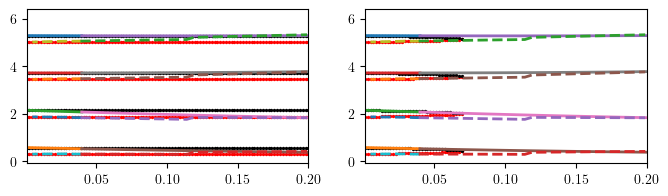

In [66]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

In [67]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(0)

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=0.0015

#### Branches eps stable

In [68]:
b=.0015
kw_b['recompute'] = False
kw_b['b'] = b

In [69]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [
    dict(phi0=2,eps_init=0.1,eps_final=0,deps=-.01),
    dict(phi0=2,eps_init=0.099,eps_final=.2,deps=.01),
]

In [70]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 2
phi init 2


In [71]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

In [72]:
data_bs_list

[array([[0.1       , 2.050605  , 2.050605  , 2.050605  , 2.050605  , 3.87543781, 5.41360178, 0.59504271, 2.12095039],
        [0.09      , 2.05467167, 2.05467167, 2.05467167, 2.05467167, 3.86246687, 5.40512953, 0.59671912, 2.12653816],
        [0.08      , 2.05867168, 2.05867168, 2.05867168, 2.05867168, 3.85007877, 5.39584816, 0.59739093, 2.13156248],
        [0.07      , 2.06287169, 2.06287169, 2.06287169, 2.06287169, 5.33531635, 0.54723797, 2.08559598, 3.78538411],
        [0.06      , 2.06713837, 2.06713837, 2.06713837, 2.06713837, 5.33484115, 0.55725351, 2.09993386, 3.78121836],
        [0.05      , 2.07147171, 2.07147171, 2.07147171, 2.07147171, 5.33500508, 0.56741175, 2.11515571, 3.7781615 ],
        [0.04      , 2.07593839, 2.07593839, 2.07593839, 2.07593839, 5.33462388, 0.57849938, 2.1309843 , 3.77548027],
        [0.03      , 2.08040507, 2.08040507, 2.08040507, 2.08040507, 5.33484836, 0.58893537, 2.14553684, 3.77160249],
        [0.02      , 2.08500508, 2.08500508, 2.08500508,

#### Branches eps unstable

Obtain an unstable phase-locked state with parameters that make one easy to find ($b=0$ and $|\varepsilon| \ll 1$) and use it to find an unstable phase-locked state for $b\neq0$.

In [73]:
kw_b['recompute'] = False
kw_b['b'] = 0
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.3,eps_init=0.01,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = .001
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.3,eps_init=0.02,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = .0012
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.3,eps_init=0.03,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = .0013
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.3,eps_init=0.035,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = .001499
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.3,eps_init=0.04,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da,list(Yinit))

phi init 3.3
phase_diffs_u_init=3.3_nm=34_b=0_ei=0.01_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.3_nm=34_b=0_ei=0.01_ef=0_de=-2.txt
[0.01       2.08927176 2.08927176 2.08927176 2.08927176 1.59229898 3.17738028 4.75704834 0.03247953]
phi init 3.3
phase_diffs_u_init=3.3_nm=34_b=0.001_ei=0.02_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.3_nm=34_b=0.001_ei=0.02_ef=0_de=-2.txt
[0.02       2.08447174 2.08447174 2.08447174 2.08447174 1.71171435 3.31431142 4.89761705 0.1615659 ]
phi init 3.3
phase_diffs_u_init=3.3_nm=34_b=0.0012_ei=0.03_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.3_nm=34_b=0.0012_ei=0.03_ef=0_de=-2.txt
[0.03       2.07980507 2.07980507 2.07980507 2.07980507 1.73045896 3.35034739 4.93821267 0.19093053]
phi init 3.3
phase_diffs_u_init=3.3_nm=34_b=0.0013_ei=0.035_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.3_nm=34_b=0.0013_ei=0.035_ef=0_de=-2.txt
[0.035      2.07753839 2.07753839 2.07753839 2.07753839 1.74121838 3.37053585 4.95932705 0.20626058]
phi init 3.3
phase_diffs_u_init=3.3_nm=34_b=0.001499_e

In [74]:
kw_b['recompute'] = False
kw_b['b'] = b

In [75]:
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.4,eps_init=0.04,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)

phi init 3.4
phase_diffs_u_init=3.4_nm=34_b=0.0015_ei=0.04_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.4_nm=34_b=0.0015_ei=0.04_ef=0_de=-2.txt
[0.04       2.07533839 2.07533839 2.07533839 2.07533839 4.99102494 0.23291988 1.76344973 3.40236604]


In [76]:
in_dicts = [
    dict(phi0=3,eps_init=0.04,eps_final=0,deps=-.002),
    dict(phi0=3,eps_init=0.039,eps_final=0.2,deps=.002),
]

In [77]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 3
phase_diffs_u_init=3_nm=34_b=0.0015_ei=0.04_ef=0_de=-0.002.txt
phase_diffs_u_pt_init=3_nm=34_b=0.0015_ei=0.04_ef=0_de=-0.002.txt
phi init 3
phase_diffs_u_init=3_nm=34_b=0.0015_ei=0.039_ef=0.2_de=0.002.txt
phase_diffs_u_pt_init=3_nm=34_b=0.0015_ei=0.039_ef=0.2_de=0.002.txt


In [78]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

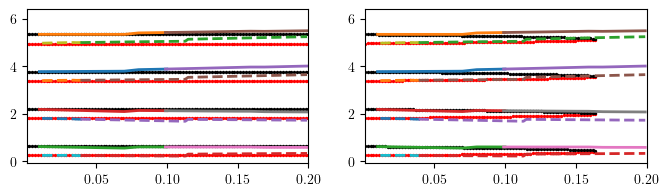

In [79]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

In [80]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(0)

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.0019

#### Branches eps stable

In [81]:
b=-0.0019
kw_b['recompute'] = False
kw_b['b'] = b

In [82]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [
    dict(phi0=2,eps_init=0.05,eps_final=0,deps=-.01),
    dict(phi0=2,eps_init=0.049,eps_final=.2,deps=.01),
]

In [83]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 2
phi init 2


In [84]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

Obtain an unstable phase-locked state with parameters that make one easy to find ($b=0$ and $|\varepsilon| \ll 1$) and use it to find an unstable phase-locked state for $b\neq0$.

In [85]:
kw_b['recompute'] = False
kw_b['b'] = 0
da,Yinit = follow_phase_diffs(c_sign=-1,**dict(phi0=0,eps_init=0.04,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = 0
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.04,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da,list(Yinit))
kw_b['b'] = -.001001
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.04,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.0015
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.04,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.0019
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.04,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)

phi init 0
[0.04       2.11587182 2.11587182 2.11587182 2.11587182 1.64830175 3.16178564 4.69308686 0.03028947]
phi init 0
phase_diffs_u_init=0_nm=34_b=0_ei=0.04_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=0_ei=0.04_ef=0_de=-2.txt
[0.04       2.07460505 2.07460505 2.07460505 2.07460505 4.79128466 0.0314977  1.5585304  3.18793062] [-0.37623278021069134, 0.077832972884727, 0.08847590287218318, 0.28992456221204227, -0.4484828702765177, 0.09059861222072976, 0.08878168766203551, 0.21268497999123703, 6.22388167936219]
phi init 0
phase_diffs_u_init=0_nm=34_b=-0.001001_ei=0.04_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.001001_ei=0.04_ef=0_de=-2.txt
[0.04       2.07433839 2.07433839 2.07433839 2.07433839 4.67235551 6.19574776 1.43777212 3.06112184]
phi init 0
phase_diffs_u_init=0_nm=34_b=-0.0015_ei=0.04_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.0015_ei=0.04_ef=0_de=-2.txt
[0.04       2.07433839 2.07433839 2.07433839 2.07433839 4.606323   6.12971525 1.37234541 2.99145451]
phi i

In [87]:
kw_b['recompute'] = False
kw_b['b'] = 0
da,Yinit = follow_phase_diffs(c_sign=-1,**dict(phi0=0,eps_init=0.04,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)
print(da)
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.04,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da,list(Yinit))
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.05,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da,list(Yinit))
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.06,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da,list(Yinit))
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.07,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da,list(Yinit))
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.08,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da,list(Yinit))
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.09,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da,list(Yinit))
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.1,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da,list(Yinit))

phi init 0
[0.04       2.11587182 2.11587182 2.11587182 2.11587182 1.64830175 3.16178564 4.69308686 0.03028947]
phi init 0
phase_diffs_u_init=0_nm=34_b=0_ei=0.04_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=0_ei=0.04_ef=0_de=-2.txt
[0.04       2.07460505 2.07460505 2.07460505 2.07460505 4.79128466 0.0314977  1.5585304  3.18793062] [-0.37623278021069134, 0.077832972884727, 0.08847590287218318, 0.28992456221204227, -0.4484828702765177, 0.09059861222072976, 0.08878168766203551, 0.21268497999123703, 6.22388167936219]
phi init 0
phase_diffs_u_init=0_nm=34_b=0_ei=0.05_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=0_ei=0.05_ef=0_de=-2.txt
iter, eps phase_diffs 0 0.05 [4.80193196 0.03035355 1.54803116 3.19319369]                

phase diff [[4.80193196 0.03035355 1.54803116 3.19319369]]
[[0.05       2.0700281  2.0700281  2.0700281  2.0700281  4.80193196 0.03035355 1.54803116 3.19319369]] [-0.3754039062900423, 0.07788136422724407, 0.08767110088986244, 0.29013252697935843, -0.448711002404790

In [87]:
in_dicts = [
    dict(phi0=3,eps_init=0.04,eps_final=0,deps=-.005),
    dict(phi0=3,eps_init=0.039,eps_final=0.2,deps=.005),
]

In [88]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 3
phase_diffs_u_init=3_nm=34_b=-0.0019_ei=0.04_ef=0_de=-0.005.txt
phase_diffs_u_pt_init=3_nm=34_b=-0.0019_ei=0.04_ef=0_de=-0.005.txt
phi init 3
phase_diffs_u_init=3_nm=34_b=-0.0019_ei=0.039_ef=0.2_de=0.005.txt
phase_diffs_u_pt_init=3_nm=34_b=-0.0019_ei=0.039_ef=0.2_de=0.005.txt


In [89]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

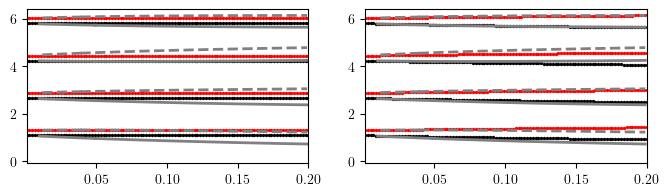

In [90]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

In [91]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(0)

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.003

#### Branches eps stable

In [92]:
b=-0.003
kw_b['recompute'] = False
kw_b['b'] = b

In [93]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [
    dict(phi0=2,eps_init=0.15,eps_final=0,deps=-.005),
    dict(phi0=2,eps_init=0.149,eps_final=.2,deps=.005),
]

In [94]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 2
phi init 2


In [95]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

Obtain an unstable phase-locked state with parameters that make one easy to find ($b=0$ and $|\varepsilon| \ll 1$) and use it to find an unstable phase-locked state for $b\neq0$.

In [96]:
kw_b['recompute'] = False
kw_b['b'] = 0
da,Yinit = follow_phase_diffs(c_sign=-1,**dict(phi0=0,eps_init=0.04,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = 0
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.04,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.001001
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.04,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.0015
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.04,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.0019
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.04,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.0022
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.05,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)

phi init 0
[0.04       2.11587182 2.11587182 2.11587182 2.11587182 1.64830175 3.16178564 4.69308686 0.03028947]
phi init 0
phase_diffs_u_init=0_nm=34_b=0_ei=0.04_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=0_ei=0.04_ef=0_de=-2.txt
[0.04       2.07460505 2.07460505 2.07460505 2.07460505 4.79128466 0.0314977  1.5585304  3.18793062]
phi init 0
phase_diffs_u_init=0_nm=34_b=-0.001001_ei=0.04_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.001001_ei=0.04_ef=0_de=-2.txt
[0.04       2.07433839 2.07433839 2.07433839 2.07433839 4.67235551 6.19574776 1.43777212 3.06112184]
phi init 0
phase_diffs_u_init=0_nm=34_b=-0.0015_ei=0.04_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.0015_ei=0.04_ef=0_de=-2.txt
[0.04       2.07433839 2.07433839 2.07433839 2.07433839 4.606323   6.12971525 1.37234541 2.99145451]
phi init 0
phase_diffs_u_init=0_nm=34_b=-0.0019_ei=0.04_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.0019_ei=0.04_ef=0_de=-2.txt
[0.04       2.07427172 2.07427172 2.07427172 2.07427172 4

In [97]:
kw_b['b'] = -.0024
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.06,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.0026
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.065,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.0026
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.07,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.0026
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.08,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.0026
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.09,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.0026
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.1,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.0027
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.11,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)

phi init 0
phase_diffs_u_init=0_nm=34_b=-0.0024_ei=0.06_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.0024_ei=0.06_ef=0_de=-2.txt
[0.06       2.0648717  2.0648717  2.0648717  2.0648717  4.50004519 6.00222409 1.22243485 2.85241561]
phi init 0
phase_diffs_u_init=0_nm=34_b=-0.0026_ei=0.065_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.0026_ei=0.065_ef=0_de=-2.txt
[0.065      2.06260502 2.06260502 2.06260502 2.06260502 4.46274919 5.96150182 1.17585064 2.80559181]
phi init 0
phase_diffs_u_init=0_nm=34_b=-0.0026_ei=0.07_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.0026_ei=0.07_ef=0_de=-2.txt
[0.07       2.06027169 2.06027169 2.06027169 2.06027169 4.48813473 5.98024892 1.18978774 2.82645749]
phi init 0
phase_diffs_u_init=0_nm=34_b=-0.0026_ei=0.08_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.0026_ei=0.08_ef=0_de=-2.txt
[0.08       2.05567167 2.05567167 2.05567167 2.05567167 4.52690919 6.00707971 1.20589884 2.85601185]
phi init 0
phase_diffs_u_init=0_nm=34_b=-0.0026_ei=0.09_ef

In [98]:
kw_b['b'] = -.0028
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.12,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.0029
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.13,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.003
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.14,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)

phi init 0
phase_diffs_u_init=0_nm=34_b=-0.0028_ei=0.12_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.0028_ei=0.12_ef=0_de=-2.txt
[0.12       2.0383383  2.0383383  2.0383383  2.0383383  4.61801276 6.05364097 1.2122489  2.91420608]
phi init 0
phase_diffs_u_init=0_nm=34_b=-0.0029_ei=0.13_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.0029_ei=0.13_ef=0_de=-2.txt
[0.13       2.03427162 2.03427162 2.03427162 2.03427162 4.63692239 6.06162447 1.21055405 2.92620916]
phi init 0
phase_diffs_u_init=0_nm=34_b=-0.003_ei=0.14_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.003_ei=0.14_ef=0_de=-2.txt
[0.14       2.03020495 2.03020495 2.03020495 2.03020495 4.65652675 6.07087789 1.21070934 2.94011725]


In [99]:
in_dicts = [
    dict(phi0=3,eps_init=0.14,eps_final=0,deps=-.005),
    dict(phi0=3,eps_init=0.139,eps_final=0.2,deps=.005),
]

In [100]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 3
phase_diffs_u_init=3_nm=34_b=-0.003_ei=0.14_ef=0_de=-0.005.txt
phase_diffs_u_pt_init=3_nm=34_b=-0.003_ei=0.14_ef=0_de=-0.005.txt
phi init 3
phase_diffs_u_init=3_nm=34_b=-0.003_ei=0.139_ef=0.2_de=0.005.txt
phase_diffs_u_pt_init=3_nm=34_b=-0.003_ei=0.139_ef=0.2_de=0.005.txt


In [101]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

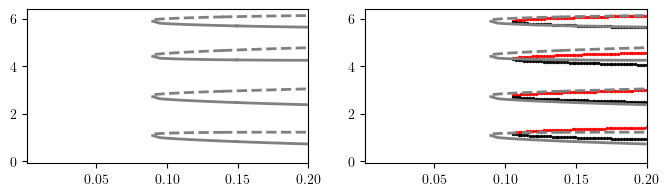

In [102]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [103]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.08999999999999994 4.411889257385905
phi init 4.411889257385905
Y [-0.11081372  0.23965866  0.08714219  0.38637181 -0.61729841  0.42142938  0.08988764  0.00766809  6.15464627]
mkdir ./data/thal2_34_b0=-0.003/
* Loading LC data...
self.T 6.154646252508573
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0019085111775923214
es_min,phi0 0.09049999999999994 4.411889257385905
phi init 4.411889257385905
Y [-0.1107673   0.23823494  0.08710805  0.38806725 -0.61705146  0.42238782  0.08986335  0.00758425  6.15402287]
mkdir ./data/thal2_34_b1=-0.003/
* Loading LC data...
self.T 6.154022860902221
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0021045986399839955
es_min,phi0 0.09099999999999994 4.411889257385905
phi init 4.411889257385905
Y [-1.15264779e-01  2.20604442e-01  8.71052190e-02  4.04145251e-01 -4.89525821e-01  6.42162670e-01  9.08040608e-02  9.63661467e-05  6.15339764e+00]
mkdir ./data/thal2_34_b2=-0.003/
* Load

In [104]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.004

#### Branches eps stable

In [105]:
b=-0.004
kw_b['recompute'] = False
kw_b['b'] = b

In [106]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [
    dict(phi0=2,eps_init=0.15,eps_final=0,deps=-.005),
    dict(phi0=2,eps_init=0.149,eps_final=.2,deps=.005),
]

In [107]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 2
phi init 2


In [108]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

Obtain an unstable phase-locked state with parameters that make one easy to find ($b=0$ and $|\varepsilon| \ll 1$) and use it to find an unstable phase-locked state for $b\neq0$.

In [109]:
kw_b['recompute'] = False
kw_b['b'] = 0
da,Yinit = follow_phase_diffs(c_sign=-1,**dict(phi0=0,eps_init=0.04,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = 0
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.04,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.001001
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.04,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.0015
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.04,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.0019
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.04,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.0022
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.05,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)

phi init 0
[0.04       2.11587182 2.11587182 2.11587182 2.11587182 1.64830175 3.16178564 4.69308686 0.03028947]
phi init 0
phase_diffs_u_init=0_nm=34_b=0_ei=0.04_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=0_ei=0.04_ef=0_de=-2.txt
[0.04       2.07460505 2.07460505 2.07460505 2.07460505 4.79128466 0.0314977  1.5585304  3.18793062]
phi init 0
phase_diffs_u_init=0_nm=34_b=-0.001001_ei=0.04_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.001001_ei=0.04_ef=0_de=-2.txt
[0.04       2.07433839 2.07433839 2.07433839 2.07433839 4.67235551 6.19574776 1.43777212 3.06112184]
phi init 0
phase_diffs_u_init=0_nm=34_b=-0.0015_ei=0.04_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.0015_ei=0.04_ef=0_de=-2.txt
[0.04       2.07433839 2.07433839 2.07433839 2.07433839 4.606323   6.12971525 1.37234541 2.99145451]
phi init 0
phase_diffs_u_init=0_nm=34_b=-0.0019_ei=0.04_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.0019_ei=0.04_ef=0_de=-2.txt
[0.04       2.07427172 2.07427172 2.07427172 2.07427172 4

In [110]:
kw_b['b'] = -.0024
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.06,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.0026
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.065,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.0026
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.07,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.0026
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.08,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.0026
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.09,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.0026
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.1,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.0027
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.11,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)

phi init 0
phase_diffs_u_init=0_nm=34_b=-0.0024_ei=0.06_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.0024_ei=0.06_ef=0_de=-2.txt
[0.06       2.0648717  2.0648717  2.0648717  2.0648717  4.50004519 6.00222409 1.22243485 2.85241561]
phi init 0
phase_diffs_u_init=0_nm=34_b=-0.0026_ei=0.065_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.0026_ei=0.065_ef=0_de=-2.txt
[0.065      2.06260502 2.06260502 2.06260502 2.06260502 4.46274919 5.96150182 1.17585064 2.80559181]
phi init 0
phase_diffs_u_init=0_nm=34_b=-0.0026_ei=0.07_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.0026_ei=0.07_ef=0_de=-2.txt
[0.07       2.06027169 2.06027169 2.06027169 2.06027169 4.48813473 5.98024892 1.18978774 2.82645749]
phi init 0
phase_diffs_u_init=0_nm=34_b=-0.0026_ei=0.08_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.0026_ei=0.08_ef=0_de=-2.txt
[0.08       2.05567167 2.05567167 2.05567167 2.05567167 4.52690919 6.00707971 1.20589884 2.85601185]
phi init 0
phase_diffs_u_init=0_nm=34_b=-0.0026_ei=0.09_ef

In [111]:
kw_b['b'] = -.0028
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.12,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.0029
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.13,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.003
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.14,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.0035
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.14,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.004
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.14,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)

phi init 0
phase_diffs_u_init=0_nm=34_b=-0.0028_ei=0.12_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.0028_ei=0.12_ef=0_de=-2.txt
[0.12       2.0383383  2.0383383  2.0383383  2.0383383  4.61801276 6.05364097 1.2122489  2.91420608]
phi init 0
phase_diffs_u_init=0_nm=34_b=-0.0029_ei=0.13_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.0029_ei=0.13_ef=0_de=-2.txt
[0.13       2.03427162 2.03427162 2.03427162 2.03427162 4.63692239 6.06162447 1.21055405 2.92620916]
phi init 0
phase_diffs_u_init=0_nm=34_b=-0.003_ei=0.14_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.003_ei=0.14_ef=0_de=-2.txt
[0.14       2.03020495 2.03020495 2.03020495 2.03020495 4.65652675 6.07087789 1.21070934 2.94011725]
phi init 0
phase_diffs_u_init=0_nm=34_b=-0.0035_ei=0.14_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.0035_ei=0.14_ef=0_de=-2.txt
[0.14       2.03027161 2.03027161 2.03027161 2.03027161 4.64853379 6.06304481 1.20303584 2.93011748]
phi init 0
phase_diffs_u_init=0_nm=34_b=-0.004_ei=0.14_ef=0_de

In [112]:
in_dicts = [
    dict(phi0=3,eps_init=0.14,eps_final=0,deps=-.005),
    dict(phi0=3,eps_init=0.139,eps_final=0.2,deps=.005),
]

In [113]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 3
phase_diffs_u_init=3_nm=34_b=-0.004_ei=0.14_ef=0_de=-0.005.txt
phase_diffs_u_pt_init=3_nm=34_b=-0.004_ei=0.14_ef=0_de=-0.005.txt
phi init 3
phase_diffs_u_init=3_nm=34_b=-0.004_ei=0.139_ef=0.2_de=0.005.txt
phase_diffs_u_pt_init=3_nm=34_b=-0.004_ei=0.139_ef=0.2_de=0.005.txt


In [114]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

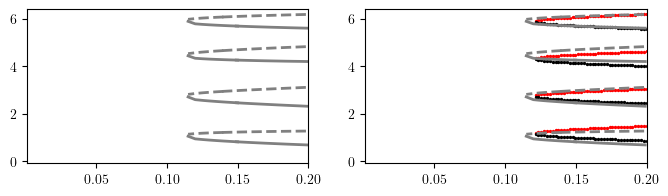

In [115]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [116]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.11499999999999996 4.432219506181746
phi init 4.432219506181746
Y [-1.17272509e-01  2.34848342e-01  8.56815962e-02  3.84145066e-01 -4.92712904e-01  6.39256112e-01  8.88677581e-02  1.05672252e-04  6.12244273e+00]
mkdir ./data/thal2_34_b0=-0.004/
* Loading LC data...
self.T 6.122442719642201
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = (-0.0032541624134753253+0j)
es_min,phi0 0.11549999999999996 4.432219506181746
phi init 4.432219506181746
Y [-0.11124929  0.22618667  0.0840029   0.40004002 -0.38490234  0.0785651   0.0843425   0.28008265  6.12186679]
mkdir ./data/thal2_34_b1=-0.004/
* Loading LC data...
self.T 6.121866789091693
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = (-0.0035637909945125607+0j)
es_min,phi0 0.11599999999999996 4.432219506181746
phi init 4.432219506181746
Y [-0.11123394  0.22609208  0.08397159  0.4001809  -0.38740874  0.07893486  0.08429421  0.27721675  6.12128839]
mkdir ./data/thal2_34_b2=-0.0

In [117]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.005

#### Branches eps stable

In [118]:
b=-0.005
kw_b['recompute'] = False
kw_b['b'] = b

In [119]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [
    dict(phi0=2,eps_init=0.15,eps_final=0,deps=-.005),
    dict(phi0=2,eps_init=0.149,eps_final=.2,deps=.005),
]

In [120]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 2
phi init 2


In [121]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

Obtain an unstable phase-locked state with parameters that make one easy to find ($b=0$ and $|\varepsilon| \ll 1$) and use it to find an unstable phase-locked state for $b\neq0$.

In [122]:
kw_b['recompute'] = False
kw_b['b'] = 0
da,Yinit = follow_phase_diffs(c_sign=-1,**dict(phi0=0,eps_init=0.04,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = 0
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.04,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.001001
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.04,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.0015
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.04,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.0019
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.04,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.0022
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.05,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)

phi init 0
[0.04       2.11587182 2.11587182 2.11587182 2.11587182 1.64830175 3.16178564 4.69308686 0.03028947]
phi init 0
phase_diffs_u_init=0_nm=34_b=0_ei=0.04_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=0_ei=0.04_ef=0_de=-2.txt
[0.04       2.07460505 2.07460505 2.07460505 2.07460505 4.79128466 0.0314977  1.5585304  3.18793062]
phi init 0
phase_diffs_u_init=0_nm=34_b=-0.001001_ei=0.04_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.001001_ei=0.04_ef=0_de=-2.txt
[0.04       2.07433839 2.07433839 2.07433839 2.07433839 4.67235551 6.19574776 1.43777212 3.06112184]
phi init 0
phase_diffs_u_init=0_nm=34_b=-0.0015_ei=0.04_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.0015_ei=0.04_ef=0_de=-2.txt
[0.04       2.07433839 2.07433839 2.07433839 2.07433839 4.606323   6.12971525 1.37234541 2.99145451]
phi init 0
phase_diffs_u_init=0_nm=34_b=-0.0019_ei=0.04_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.0019_ei=0.04_ef=0_de=-2.txt
[0.04       2.07427172 2.07427172 2.07427172 2.07427172 4

In [123]:
kw_b['b'] = -.0024
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.06,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.0026
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.065,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.0026
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.07,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.0026
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.08,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.0026
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.09,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.0026
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.1,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.0027
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.11,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)

phi init 0
phase_diffs_u_init=0_nm=34_b=-0.0024_ei=0.06_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.0024_ei=0.06_ef=0_de=-2.txt
[0.06       2.0648717  2.0648717  2.0648717  2.0648717  4.50004519 6.00222409 1.22243485 2.85241561]
phi init 0
phase_diffs_u_init=0_nm=34_b=-0.0026_ei=0.065_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.0026_ei=0.065_ef=0_de=-2.txt
[0.065      2.06260502 2.06260502 2.06260502 2.06260502 4.46274919 5.96150182 1.17585064 2.80559181]
phi init 0
phase_diffs_u_init=0_nm=34_b=-0.0026_ei=0.07_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.0026_ei=0.07_ef=0_de=-2.txt
[0.07       2.06027169 2.06027169 2.06027169 2.06027169 4.48813473 5.98024892 1.18978774 2.82645749]
phi init 0
phase_diffs_u_init=0_nm=34_b=-0.0026_ei=0.08_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.0026_ei=0.08_ef=0_de=-2.txt
[0.08       2.05567167 2.05567167 2.05567167 2.05567167 4.52690919 6.00707971 1.20589884 2.85601185]
phi init 0
phase_diffs_u_init=0_nm=34_b=-0.0026_ei=0.09_ef

In [124]:
kw_b['b'] = -.0028
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.12,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.0029
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.13,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.003
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.14,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.0035
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.14,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.004
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.14,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)

phi init 0
phase_diffs_u_init=0_nm=34_b=-0.0028_ei=0.12_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.0028_ei=0.12_ef=0_de=-2.txt
[0.12       2.0383383  2.0383383  2.0383383  2.0383383  4.61801276 6.05364097 1.2122489  2.91420608]
phi init 0
phase_diffs_u_init=0_nm=34_b=-0.0029_ei=0.13_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.0029_ei=0.13_ef=0_de=-2.txt
[0.13       2.03427162 2.03427162 2.03427162 2.03427162 4.63692239 6.06162447 1.21055405 2.92620916]
phi init 0
phase_diffs_u_init=0_nm=34_b=-0.003_ei=0.14_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.003_ei=0.14_ef=0_de=-2.txt
[0.14       2.03020495 2.03020495 2.03020495 2.03020495 4.65652675 6.07087789 1.21070934 2.94011725]
phi init 0
phase_diffs_u_init=0_nm=34_b=-0.0035_ei=0.14_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.0035_ei=0.14_ef=0_de=-2.txt
[0.14       2.03027161 2.03027161 2.03027161 2.03027161 4.64853379 6.06304481 1.20303584 2.93011748]
phi init 0
phase_diffs_u_init=0_nm=34_b=-0.004_ei=0.14_ef=0_de

In [125]:
kw_b['b'] = -.0045
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.14,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.005
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.14,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)

phi init 0
phase_diffs_u_init=0_nm=34_b=-0.0045_ei=0.14_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.0045_ei=0.14_ef=0_de=-2.txt
[0.14       2.03027161 2.03027161 2.03027161 2.03027161 4.66957815 6.08347022 1.22346125 2.9567324 ]
phi init 0
phase_diffs_u_init=0_nm=34_b=-0.005_ei=0.14_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.005_ei=0.14_ef=0_de=-2.txt
[0.14       2.03040495 2.03040495 2.03040495 2.03040495 4.69567838 6.10927129 1.25020039 2.98995944]


In [126]:
in_dicts = [
    dict(phi0=3,eps_init=0.14,eps_final=0,deps=-.005),
    dict(phi0=3,eps_init=0.139,eps_final=0.2,deps=.005),
]

In [127]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 3
phase_diffs_u_init=3_nm=34_b=-0.005_ei=0.14_ef=0_de=-0.005.txt
phase_diffs_u_pt_init=3_nm=34_b=-0.005_ei=0.14_ef=0_de=-0.005.txt
phi init 3
phase_diffs_u_init=3_nm=34_b=-0.005_ei=0.139_ef=0.2_de=0.005.txt
phase_diffs_u_pt_init=3_nm=34_b=-0.005_ei=0.139_ef=0.2_de=0.005.txt


In [128]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

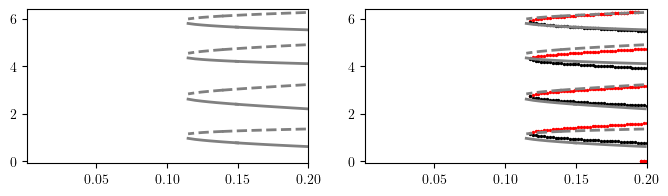

In [129]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [130]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.11499999999999996 4.3421771260148105
phi init 4.3421771260148105
Y [-0.11117336  0.23047903  0.08406799  0.3950391  -0.38951544  0.07925139  0.08434616  0.2749456   6.12268032]
mkdir ./data/thal2_34_b0=-0.005/
* Loading LC data...
self.T 6.122680321337884
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.004460853883399169
es_min,phi0 0.11549999999999996 4.3421771260148105
phi init 4.3421771260148105
Y [-0.111128    0.2288355   0.08403311  0.39706762 -0.39376534  0.0799161   0.08428778  0.27010911  6.1221208 ]
mkdir ./data/thal2_34_b1=-0.005/
* Loading LC data...
self.T 6.122120795390753
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.004825337679579371
es_min,phi0 0.11599999999999996 4.3421771260148105
phi init 4.3421771260148105
Y [-0.11144261  0.23221566  0.08555194  0.39428928 -0.61558431  0.42198445  0.08771539  0.00754918  6.12155881]
mkdir ./data/thal2_34_b2=-0.005/
* Loading LC data...
self.T 6.12155880

In [131]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.006

#### Branches eps stable

In [132]:
b=-0.006
kw_b['recompute'] = False
kw_b['b'] = b

In [133]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [
    dict(phi0=2,eps_init=0.15,eps_final=0,deps=-.005),
    dict(phi0=2,eps_init=0.149,eps_final=.2,deps=.005),
]

In [134]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 2
phi init 2


In [135]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

Obtain an unstable phase-locked state with parameters that make one easy to find ($b=0$ and $|\varepsilon| \ll 1$) and use it to find an unstable phase-locked state for $b\neq0$.

In [136]:
kw_b['recompute'] = False
kw_b['b'] = 0
da,Yinit = follow_phase_diffs(c_sign=-1,**dict(phi0=0,eps_init=0.04,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = 0
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.04,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.001001
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.04,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.0015
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.04,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.0019
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.04,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.0022
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.05,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)

phi init 0
[0.04       2.11587182 2.11587182 2.11587182 2.11587182 1.64830175 3.16178564 4.69308686 0.03028947]
phi init 0
phase_diffs_u_init=0_nm=34_b=0_ei=0.04_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=0_ei=0.04_ef=0_de=-2.txt
[0.04       2.07460505 2.07460505 2.07460505 2.07460505 4.79128466 0.0314977  1.5585304  3.18793062]
phi init 0
phase_diffs_u_init=0_nm=34_b=-0.001001_ei=0.04_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.001001_ei=0.04_ef=0_de=-2.txt
[0.04       2.07433839 2.07433839 2.07433839 2.07433839 4.67235551 6.19574776 1.43777212 3.06112184]
phi init 0
phase_diffs_u_init=0_nm=34_b=-0.0015_ei=0.04_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.0015_ei=0.04_ef=0_de=-2.txt
[0.04       2.07433839 2.07433839 2.07433839 2.07433839 4.606323   6.12971525 1.37234541 2.99145451]
phi init 0
phase_diffs_u_init=0_nm=34_b=-0.0019_ei=0.04_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.0019_ei=0.04_ef=0_de=-2.txt
[0.04       2.07427172 2.07427172 2.07427172 2.07427172 4

In [137]:
kw_b['b'] = -.0024
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.06,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.0026
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.065,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.0026
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.07,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.0026
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.08,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.0026
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.09,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.0026
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.1,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.0027
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.11,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)

phi init 0
phase_diffs_u_init=0_nm=34_b=-0.0024_ei=0.06_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.0024_ei=0.06_ef=0_de=-2.txt
[0.06       2.0648717  2.0648717  2.0648717  2.0648717  4.50004519 6.00222409 1.22243485 2.85241561]
phi init 0
phase_diffs_u_init=0_nm=34_b=-0.0026_ei=0.065_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.0026_ei=0.065_ef=0_de=-2.txt
[0.065      2.06260502 2.06260502 2.06260502 2.06260502 4.46274919 5.96150182 1.17585064 2.80559181]
phi init 0
phase_diffs_u_init=0_nm=34_b=-0.0026_ei=0.07_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.0026_ei=0.07_ef=0_de=-2.txt
[0.07       2.06027169 2.06027169 2.06027169 2.06027169 4.48813473 5.98024892 1.18978774 2.82645749]
phi init 0
phase_diffs_u_init=0_nm=34_b=-0.0026_ei=0.08_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.0026_ei=0.08_ef=0_de=-2.txt
[0.08       2.05567167 2.05567167 2.05567167 2.05567167 4.52690919 6.00707971 1.20589884 2.85601185]
phi init 0
phase_diffs_u_init=0_nm=34_b=-0.0026_ei=0.09_ef

In [138]:
kw_b['b'] = -.0028
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.12,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.0029
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.13,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.003
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.14,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.0035
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.14,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.004
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.14,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)

phi init 0
phase_diffs_u_init=0_nm=34_b=-0.0028_ei=0.12_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.0028_ei=0.12_ef=0_de=-2.txt
[0.12       2.0383383  2.0383383  2.0383383  2.0383383  4.61801276 6.05364097 1.2122489  2.91420608]
phi init 0
phase_diffs_u_init=0_nm=34_b=-0.0029_ei=0.13_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.0029_ei=0.13_ef=0_de=-2.txt
[0.13       2.03427162 2.03427162 2.03427162 2.03427162 4.63692239 6.06162447 1.21055405 2.92620916]
phi init 0
phase_diffs_u_init=0_nm=34_b=-0.003_ei=0.14_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.003_ei=0.14_ef=0_de=-2.txt
[0.14       2.03020495 2.03020495 2.03020495 2.03020495 4.65652675 6.07087789 1.21070934 2.94011725]
phi init 0
phase_diffs_u_init=0_nm=34_b=-0.0035_ei=0.14_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.0035_ei=0.14_ef=0_de=-2.txt
[0.14       2.03027161 2.03027161 2.03027161 2.03027161 4.64853379 6.06304481 1.20303584 2.93011748]
phi init 0
phase_diffs_u_init=0_nm=34_b=-0.004_ei=0.14_ef=0_de

In [139]:
kw_b['b'] = -.0045
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.14,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.005
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.14,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.006
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.14,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)

phi init 0
phase_diffs_u_init=0_nm=34_b=-0.0045_ei=0.14_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.0045_ei=0.14_ef=0_de=-2.txt
[0.14       2.03027161 2.03027161 2.03027161 2.03027161 4.66957815 6.08347022 1.22346125 2.9567324 ]
phi init 0
phase_diffs_u_init=0_nm=34_b=-0.005_ei=0.14_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.005_ei=0.14_ef=0_de=-2.txt
[0.14       2.03040495 2.03040495 2.03040495 2.03040495 4.69567838 6.10927129 1.25020039 2.98995944]
phi init 0
phase_diffs_u_init=0_nm=34_b=-0.006_ei=0.14_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.006_ei=0.14_ef=0_de=-2.txt
[0.14       2.03073828 2.03073828 2.03073828 2.03073828 4.76648324 6.18025666 1.32198334 3.07919603]


In [140]:
in_dicts = [
    dict(phi0=3,eps_init=0.14,eps_final=0,deps=-.005),
    dict(phi0=3,eps_init=0.139,eps_final=0.2,deps=.005),
]

In [141]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 3
phase_diffs_u_init=3_nm=34_b=-0.006_ei=0.14_ef=0_de=-0.005.txt
phase_diffs_u_pt_init=3_nm=34_b=-0.006_ei=0.14_ef=0_de=-0.005.txt
phi init 3
phase_diffs_u_init=3_nm=34_b=-0.006_ei=0.139_ef=0.2_de=0.005.txt
phase_diffs_u_pt_init=3_nm=34_b=-0.006_ei=0.139_ef=0.2_de=0.005.txt


In [142]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

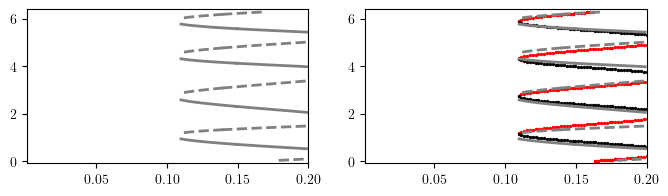

In [143]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [144]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.10999999999999996 4.306607190348624
phi init 4.306607190348624
Y [-0.11164725  0.21563706  0.08588063  0.41416141 -0.6128592   0.43371595  0.08842251  0.00660587  6.12949349]
mkdir ./data/thal2_34_b0=-0.006/
* Loading LC data...
self.T 6.12949348506065
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = (-0.006309638995260972+0j)
es_min,phi0 0.11049999999999996 4.306607190348624
phi init 4.306607190348624
Y [-0.11132259  0.22734423  0.08590243  0.40023703 -0.61382601  0.4313662   0.08830668  0.00679098  6.12893833]
mkdir ./data/thal2_34_b1=-0.006/
* Loading LC data...
self.T 6.128938331377029
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = (-0.0066628568398584+0j)
es_min,phi0 0.11099999999999996 4.306607190348624
phi init 4.306607190348624
Y [-0.11144924  0.23394791  0.08590406  0.3922501  -0.61425305  0.43045063  0.08822743  0.00686343  6.12838182]
mkdir ./data/thal2_34_b2=-0.006/
* Loading LC data...
self.T 6.1283818

In [145]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.01

#### Branches eps stable

In [146]:
b=-0.01
kw_b['recompute'] = False
kw_b['b'] = b

In [147]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [
    dict(phi0=2,eps_init=0.1,eps_final=0,deps=-.002),
    dict(phi0=2,eps_init=0.099,eps_final=.2,deps=.002),
]

In [148]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 2
phi init 2


In [149]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

Obtain an unstable phase-locked state with parameters that make one easy to find ($b=0$ and $|\varepsilon| \ll 1$) and use it to find an unstable phase-locked state for $b\neq0$.

In [150]:
kw_b['recompute'] = False
kw_b['b'] = -.005
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.14,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.01
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.1,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)

phi init 0
phase_diffs_u_init=0_nm=34_b=-0.005_ei=0.14_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.005_ei=0.14_ef=0_de=-2.txt
[0.14       2.03040495 2.03040495 2.03040495 2.03040495 4.69567838 6.10927129 1.25020039 2.98995944]
phi init 0
phase_diffs_u_init=0_nm=34_b=-0.01_ei=0.1_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.01_ei=0.1_ef=0_de=-2.txt
[0.1        2.04787166 2.04787166 2.04787166 2.04787166 4.84299038 0.01677262 1.48294464 3.20254679]


In [151]:
in_dicts = [
    dict(phi0=3,eps_init=0.1,eps_final=0,deps=-.002),
    dict(phi0=3,eps_init=0.099,eps_final=0.2,deps=.002),
]

In [152]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 3
phase_diffs_u_init=3_nm=34_b=-0.01_ei=0.1_ef=0_de=-0.002.txt
phase_diffs_u_pt_init=3_nm=34_b=-0.01_ei=0.1_ef=0_de=-0.002.txt
phi init 3
phase_diffs_u_init=3_nm=34_b=-0.01_ei=0.099_ef=0.2_de=0.002.txt
phase_diffs_u_pt_init=3_nm=34_b=-0.01_ei=0.099_ef=0.2_de=0.002.txt


In [153]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

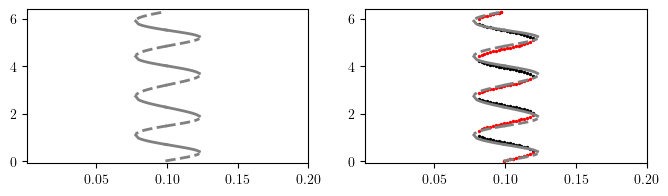

In [154]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [155]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.07799999999999999 4.407577208157645
phi init 4.407577208157645
Y [-0.11038183  0.22315918  0.08678044  0.40511595 -0.36445463  0.07589787  0.08695532  0.30473283  6.17057933]
mkdir ./data/thal2_34_b0=-0.01/
* Loading LC data...
self.T 6.170579297302675
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0011130791700445424
es_min,phi0 0.07849999999999999 4.407577208157645
phi init 4.407577208157645
Y [-0.11039844  0.21766563  0.08674661  0.41188235 -0.39104429  0.07938957  0.08675936  0.27396296  6.17026871]
mkdir ./data/thal2_34_b1=-0.01/
* Loading LC data...
self.T 6.170268706075528
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.002757494723632626
es_min,phi0 0.07899999999999999 4.407577208157645
phi init 4.407577208157645
Y [-0.11026438  0.22812103  0.08787073  0.40051299 -0.6140217   0.43868296  0.09108844  0.00630792  6.1698387 ]
mkdir ./data/thal2_34_b2=-0.01/
* Loading LC data...
self.T 6.1698386928286
lo

#### Monodromys max

In [156]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.12300000000000003 3.691140594756419
phi init 3.691140594756419
Y [-0.10882375  0.23792403  0.08533848  0.39044686 -0.58959803  0.18841385  0.08303398  0.06757489  6.12588672]
mkdir ./data/thal2_34_b0=-0.01/
* Loading LC data...
self.T 6.170579297302675
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0011130791700445424
es_min,phi0 0.12250000000000003 3.691140594756419
phi init 3.691140594756419
Y [-0.10864521  0.23151287  0.08530155  0.3980357  -0.58807997  0.18615577  0.08303839  0.06897362  6.12642873]
mkdir ./data/thal2_34_b1=-0.01/
* Loading LC data...
self.T 6.170268706075528
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.002757494723632626
es_min,phi0 0.12200000000000003 3.691140594756419
phi init 3.691140594756419
Y [-1.18359508e-01  2.15852353e-01  8.52428772e-02  4.06890524e-01 -3.96756290e-01  6.53084905e-01  8.62641042e-02  1.42570398e-05  6.12693965e+00]
mkdir ./data/thal2_34_b2=-0.01/
* Loading 

In [157]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.015

#### Branches eps stable

In [158]:
b=-0.015
kw_b['recompute'] = False
kw_b['b'] = b

In [159]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [
    dict(phi0=2.2,eps_init=0.07,eps_final=0,deps=-.002),
    dict(phi0=2.2,eps_init=0.0699,eps_final=.2,deps=.002),
]

In [160]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 2.2
phi init 2.2


In [161]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

Obtain an unstable phase-locked state with parameters that make one easy to find ($b=0$ and $|\varepsilon| \ll 1$) and use it to find an unstable phase-locked state for $b\neq0$.

In [162]:
kw_b['recompute'] = False
kw_b['b'] = -.005
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.14,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.01
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.1,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.015
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.07,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)

phi init 0
phase_diffs_u_init=0_nm=34_b=-0.005_ei=0.14_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.005_ei=0.14_ef=0_de=-2.txt
[0.14       2.03040495 2.03040495 2.03040495 2.03040495 4.69567838 6.10927129 1.25020039 2.98995944]
phi init 0
phase_diffs_u_init=0_nm=34_b=-0.01_ei=0.1_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.01_ei=0.1_ef=0_de=-2.txt
[0.1        2.04787166 2.04787166 2.04787166 2.04787166 4.84299038 0.01677262 1.48294464 3.20254679]
phi init 0
phase_diffs_u_init=0_nm=34_b=-0.015_ei=0.07_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.015_ei=0.07_ef=0_de=-2.txt
[0.07       2.06133836 2.06133836 2.06133836 2.06133836 4.90238828 0.11013863 1.60778015 3.29013756]


In [163]:
in_dicts = [
    dict(phi0=3,eps_init=0.07,eps_final=0,deps=-.002),
    dict(phi0=3,eps_init=0.0699,eps_final=0.2,deps=.002),
]

In [164]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 3
phase_diffs_u_init=3_nm=34_b=-0.015_ei=0.07_ef=0_de=-0.002.txt
phase_diffs_u_pt_init=3_nm=34_b=-0.015_ei=0.07_ef=0_de=-0.002.txt
phi init 3
phase_diffs_u_init=3_nm=34_b=-0.015_ei=0.0699_ef=0.2_de=0.002.txt
phase_diffs_u_pt_init=3_nm=34_b=-0.015_ei=0.0699_ef=0.2_de=0.002.txt


In [165]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

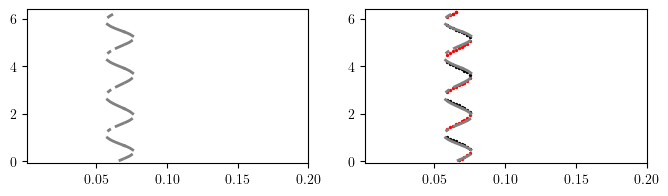

In [166]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [167]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.057999999999999996 4.2485238802345595
phi init 4.2485238802345595
Y [-0.10963987  0.23985554  0.08856959  0.38683664 -0.40854339  0.08226465  0.08797454  0.255323    6.19899969]
mkdir ./data/thal2_34_b0=-0.015/
* Loading LC data...
self.T 6.198999685325019
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.004104978184231384
es_min,phi0 0.058499999999999996 4.2485238802345595
phi init 4.2485238802345595
Y [-0.10926012  0.22380223  0.08849976  0.4061022  -0.43378601  0.08749521  0.087779    0.22789054  6.19858635]
mkdir ./data/thal2_34_b1=-0.015/
* Loading LC data...
self.T 6.198586350301573
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.004969060624167784
es_min,phi0 0.059 4.2485238802345595
phi init 4.2485238802345595
Y [-0.10932219  0.23605773  0.08853321  0.39164768 -0.43722869  0.08829675  0.0877117   0.2243666   6.19814837]
mkdir ./data/thal2_34_b2=-0.015/
* Loading LC data...
self.T 6.19814837197478
loade

In [168]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.02

#### Branches eps stable

In [169]:
b=-0.02
kw_b['recompute'] = False
kw_b['b'] = b

In [170]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [
    dict(phi0=2,eps_init=0.05,eps_final=0,deps=-.002),
    dict(phi0=2,eps_init=0.0499,eps_final=.2,deps=.002),
]

In [171]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 2
phi init 2


In [172]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

Obtain an unstable phase-locked state with parameters that make one easy to find ($b=0$ and $|\varepsilon| \ll 1$) and use it to find an unstable phase-locked state for $b\neq0$.

In [173]:
kw_b['recompute'] = False
kw_b['b'] = -.005
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.14,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.01
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.1,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.015
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.07,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.02
da,Yinit = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.05,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)

phi init 0
phase_diffs_u_init=0_nm=34_b=-0.005_ei=0.14_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.005_ei=0.14_ef=0_de=-2.txt
[0.14       2.03040495 2.03040495 2.03040495 2.03040495 4.69567838 6.10927129 1.25020039 2.98995944]
phi init 0
phase_diffs_u_init=0_nm=34_b=-0.01_ei=0.1_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.01_ei=0.1_ef=0_de=-2.txt
[0.1        2.04787166 2.04787166 2.04787166 2.04787166 4.84299038 0.01677262 1.48294464 3.20254679]
phi init 0
phase_diffs_u_init=0_nm=34_b=-0.015_ei=0.07_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.015_ei=0.07_ef=0_de=-2.txt
[0.07       2.06133836 2.06133836 2.06133836 2.06133836 4.90238828 0.11013863 1.60778015 3.29013756]
phi init 0
phase_diffs_u_init=0_nm=34_b=-0.02_ei=0.05_ef=0_de=-2.txt
phase_diffs_u_pt_init=0_nm=34_b=-0.02_ei=0.05_ef=0_de=-2.txt
[0.05       2.06993838 2.06993838 2.06993838 2.06993838 4.80127716 0.03015217 1.54646211 3.19086817]


In [174]:
in_dicts = [
    dict(phi0=3,eps_init=0.05,eps_final=0,deps=-.002),
    dict(phi0=3,eps_init=0.0499,eps_final=0.2,deps=.002),
]

In [175]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 3
phase_diffs_u_init=3_nm=34_b=-0.02_ei=0.05_ef=0_de=-0.002.txt
phase_diffs_u_pt_init=3_nm=34_b=-0.02_ei=0.05_ef=0_de=-0.002.txt
phi init 3
phase_diffs_u_init=3_nm=34_b=-0.02_ei=0.0499_ef=0.2_de=0.002.txt
phase_diffs_u_pt_init=3_nm=34_b=-0.02_ei=0.0499_ef=0.2_de=0.002.txt


In [176]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

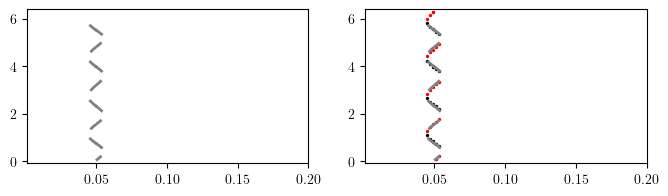

In [177]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [178]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.046 4.173561670807208
phi init 4.173561670807208
Y [-1.09429562e-01  2.20438074e-01  9.02689256e-02  4.10647919e-01 -6.06050052e-01  4.75375961e-01  9.44448823e-02  4.03872526e-03  6.21642813e+00]
mkdir ./data/thal2_34_b0=-0.02/
* Loading LC data...
self.T 6.21642813554513
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.004887192193439216
es_min,phi0 0.0465 4.173561670807208
phi init 4.173561670807208
Y [-1.09355074e-01  2.26098075e-01  9.02932095e-02  4.03952235e-01 -6.04701394e-01  4.79910673e-01  9.44416102e-02  3.80020661e-03  6.21603705e+00]
mkdir ./data/thal2_34_b1=-0.02/
* Loading LC data...
self.T 6.216037054111612
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0056127645719455865
es_min,phi0 0.047 4.173561670807208
phi init 4.173561670807208
Y [-1.11788927e-01  2.20881608e-01  9.01388769e-02  4.07630419e-01 -4.64890028e-01  6.55466727e-01  9.36289197e-02  4.86778227e-05  6.21562666e+00]
mkdir ./data

#### Monodromys max

In [179]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.0539 3.7890964829556175
phi init 3.7890964829556175
Y [-1.10112464e-01  2.26808297e-01  9.03072298e-02  4.02325061e-01 -5.80439649e-01  5.38619604e-01  9.42208028e-02  1.53676743e-03  6.20931637e+00]
mkdir ./data/thal2_34_b0=-0.02/
* Loading LC data...
self.T 6.21642813554513
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.004887192193439216
es_min,phi0 0.0534 3.7890964829556175
phi init 3.7890964829556175
Y [-0.10818229  0.23107033  0.08962809  0.39919523 -0.57145385  0.16015096  0.08728605  0.08872742  6.20981551]
mkdir ./data/thal2_34_b1=-0.02/
* Loading LC data...
self.T 6.216037054111612
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0056127645719455865
es_min,phi0 0.0529 3.7890964829556175
phi init 3.7890964829556175
Y [-0.1082653   0.22270824  0.08959249  0.40893871 -0.56818797  0.15661969  0.08731769  0.09190662  6.21030067]
mkdir ./data/thal2_34_b2=-0.02/
* Loading LC data...
self.T 6.21562666226373

In [180]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

# Two parameter full

In [181]:
fname_raw = 'thal2_{}{}_1k_o2_pos.dat'
data = np.loadtxt('../v2_bifdat_2par/redu/'+fname_raw.format(a._n[1],a._m[1]))

fname_raw = 'thal2_{}{}_1k_o2_neg.dat'
data2 = np.loadtxt('../v2_bifdat_2par/redu/'+fname_raw.format(a._n[1],a._m[1]))

fname_raw = 'thal2_{}{}_1k_o2_neg2.dat'
data3 = np.loadtxt('../v2_bifdat_2par/redu/'+fname_raw.format(a._n[1],a._m[1]))

(-0.02, 0.01)

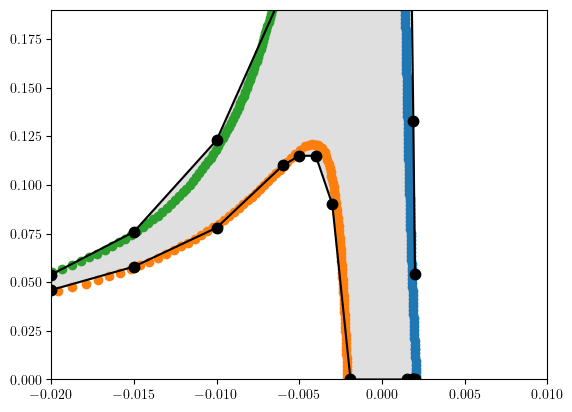

In [182]:
fig,axs = plt.subplots()
axs.fill_between(b_vals_full,e_vals_full,e_hi_full,color='gray',alpha=.25)
axs.plot(b_vals_full,e_vals_full,marker='.',color='k',markersize=15)
axs.plot(b_vals_full,e_hi_full,marker='.',color='k',markersize=15)

axs.scatter(data[:,1],data[:,0])
axs.scatter(data2[:,1],data2[:,0])
axs.scatter(data3[:,1],data3[:,0])

axs.set_ylim(0,.19)
axs.set_xlim(-.02,.01)

In [183]:
fname_lo = '../v2_bifdat_2par/full/thal2_2par_lo_{}{}.dat'.format(a._n[1],a._m[1])
fname_hi = '../v2_bifdat_2par/full/thal2_2par_hi_{}{}.dat'.format(a._n[1],a._m[1])

arr_lo = np.zeros([len(b_vals_full),2])
arr_hi = np.zeros([len(b_vals_full),2])

arr_lo[:,0] = b_vals_full
arr_lo[:,1] = e_vals_full

arr_hi[:,0] = b_vals_full
arr_hi[:,1] = e_hi_full

np.savetxt(fname_lo,arr_lo)
np.savetxt(fname_hi,arr_hi)

# Eigenvalue Convergence Plot

## Min

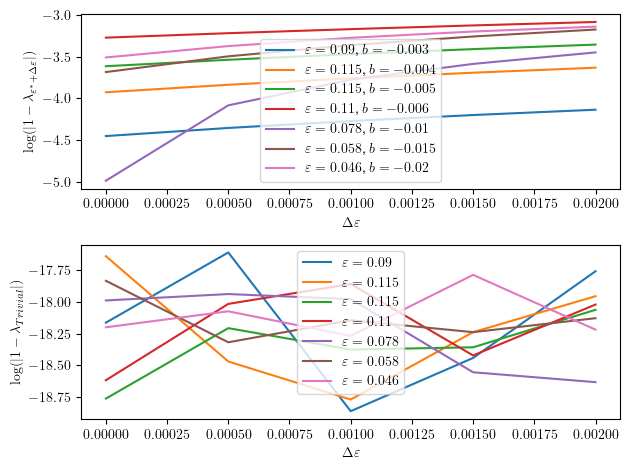

In [184]:
fig,axs = plt.subplots(2,1)

eps_values = np.arange(0,+0.0005*5,.0005)
skipn = 1

for j in range(len(eigenvalues_min_all[::skipn])):
    nn = len(eigenvalues_min_all[::skipn][j])

    at_eigen = []
    near_eigen = []
    
    for i in range(nn):
        eigenval = np.array(eigenvalues_min_all[::skipn][j][i])
        
        min1 = np.argsort(np.abs(eigenval-1))[:2]
        periodic1,bif1 = eigenval[min1]
        
        at_eigen.append(periodic1)
        near_eigen.append(bif1)

    
    ee = e_vals_mono_min[::skipn][j]
    e0 = ee[0]
    de = ee - e0
    
    axs[0].plot(eps_values,np.log(np.abs(1-np.array(near_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$, ' +r'$b='+str(b_min_all[j])+r'$')
    axs[1].plot(eps_values,np.log(np.abs(1-np.array(at_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$')
    #axs[1].plot(lc_list2,label='Near Bifurcation')

    axs[0].legend()
    axs[1].legend()

    axs[0].set_xlabel(r'$\Delta\varepsilon$')
    axs[1].set_xlabel(r'$\Delta\varepsilon$')
    #axs[1].set_xlabel('Point')
    
    axs[0].set_ylabel(r'$\log(|1 - \lambda_{\varepsilon^*+\Delta\varepsilon}|)$')
    axs[1].set_ylabel(r'$\log(|1-\lambda_{Trivial}|)$')

    plt.tight_layout()
    plt.savefig('../figs/supp_convergence_thal2_min_{}{}.png'.format(a._n[1],a._m[1]))

## Max

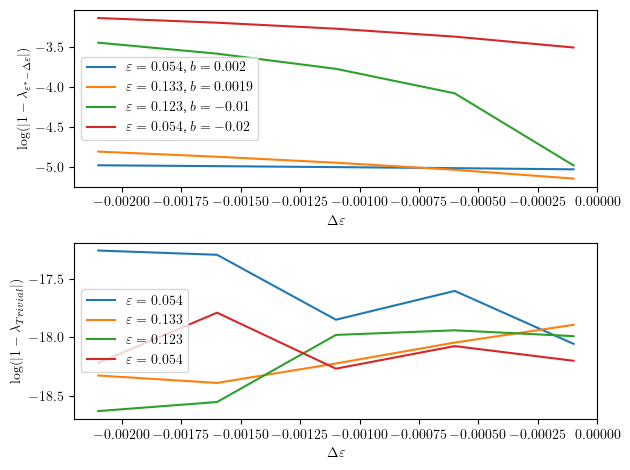

In [186]:
fig,axs = plt.subplots(2,1)

#es_min+.0001+0.0005*i
#ee = es_max-.0001-0.0005*i
eps_values = np.arange(-0.0001,0.0001-0.0005*5,-.0005)
skipn = 1

for j in range(len(eigenvalues_max_all[::skipn])):
    nn = len(eigenvalues_max_all[::skipn][j])

    at_eigen = []
    near_eigen = []
    
    for i in range(nn):
        eigenval = np.array(eigenvalues_max_all[::skipn][j][i])
        
        max1 = np.argsort(np.abs(eigenval-1))[:2]
        periodic1,bif1 = eigenval[max1]
        
        at_eigen.append(periodic1)
        near_eigen.append(bif1)

    ee = e_vals_mono_max[::skipn][j]
    e0 = ee[0]
    de = ee - e0
    
    axs[0].plot(eps_values,np.log(np.abs(1-np.array(near_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$, ' +r'$b='+str(b_max_all[j])+r'$')
    axs[1].plot(eps_values,np.log(np.abs(1-np.array(at_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$')
    #axs[1].plot(lc_list2,label='Near Bifurcation')

    axs[0].legend()
    axs[1].legend()

    axs[0].set_xlabel(r'$\Delta\varepsilon$')
    axs[1].set_xlabel(r'$\Delta\varepsilon$')
    #axs[1].set_xlabel('Point')
    
    axs[0].set_ylabel(r'$\log(|1 - \lambda_{\varepsilon^*-\Delta\varepsilon}|)$')
    axs[1].set_ylabel(r'$\log(|1-\lambda_{Trivial}|)$')

    plt.tight_layout()
    plt.savefig('../figs/supp_convergence_thal2_max_{}{}.png'.format(a._n[1],a._m[1]))